## import

In [1]:
seed = 42

# Import libraries
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

import random
random.seed(seed)
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score


from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import mutual_info_classif, SelectKBest, SelectPercentile, f_classif, f_regression, SelectFromModel
from scipy.spatial.distance import pdist, squareform
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
import statistics
from sklearn.decomposition import PCA

import pickle

## carico dati encoder

In [ ]:

file_path = "../CSV/data_rad_clin_DEF.csv"

data = pd.read_csv(file_path)
labels_column = data['label']
labels = labels_column.astype(int).tolist()

labels=np.array(labels)

# Estrazione dei numeri dai nomi dei pazienti
loaded_patients = data['IDs_new'].str.extract(r'(\d+)').astype(int).squeeze().tolist()

print("Labels:", labels)
print("Number of labels:", len(labels))
print("Patient Names: ", loaded_patients )

#file_path = "/Users/alessiamenozzi/Desktop/ThesisPlaques/ThesisPlaques/CSV/VGG19_Slice_Maggiore.csv"
#file_path = "/Users/alessiamenozzi/Desktop/ThesisPlaques/ThesisPlaques/CSV/RESNET50_Slice_Maggiore.csv"
file_path = "/Users/alessiamenozzi/Desktop/ThesisPlaques/ThesisPlaques/CSV/InceptionV3_Slice_Maggiore.csv"


df = pd.read_csv(file_path, sep=',')


df['Unnamed: 0'] = df['Unnamed: 0'].astype(int)

df_ordered = df.set_index('Unnamed: 0').loc[loaded_patients].reset_index()

df_features = df_ordered.drop(columns=['Unnamed: 0'])

features = df_features.to_numpy()

print(features)
print(features.shape)




## caricamento dati radiomica

In [110]:

file_path = "/Users/alessiamenozzi/Desktop/ThesisPlaques/ThesisPlaques/CSV/data_rad_clin_DEF.csv"

data = pd.read_csv(file_path)
labels_column = data['label']
labels = labels_column.astype(int).tolist()

labels=np.array(labels)

# Estrazione dei numeri dai nomi dei pazienti
loaded_patients = data['IDs_new'].str.extract(r'(\d+)').astype(int).squeeze().tolist()

print("Labels:", labels)
print("Number of labels:", len(labels))
print("Patient Names: ", loaded_patients )

file_path = "/Users/alessiamenozzi/Desktop/ThesisPlaques/ThesisPlaques/CSV/Radiomica_2D.csv"

df = pd.read_csv(file_path, sep=',')
#df = df.astype(float)

# Colonne da rimuovere SOLO PER RADIOMICA
columns_to_remove = [
    'Slice',
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'diagnostics_Image-original_Maximum',
    'diagnostics_Mask-original_VoxelNum',
    'diagnostics_Mask-original_VolumeNum',
]

df_cleaned = df.drop(columns=columns_to_remove)
df_features = df_cleaned.drop(columns=['Paziente'])

features = df_features.to_numpy()

print(features)
print(features.shape)  

Labels: [0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0
 0 0 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0
 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1]
Number of labels: 129
Patient Names:  [5, 12, 15, 16, 17, 19, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 35, 36, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 64, 65, 68, 69, 70, 71, 74, 75, 76, 78, 79, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 124, 126, 127, 128, 129, 133, 135, 136, 137, 138, 139, 141, 142, 144, 146, 147, 149, 150, 153, 155, 158, 159, 161, 163, 166, 168, 169, 170, 171, 175, 176, 178, 182, 183, 188, 189, 190, 193, 197, 199, 200, 205]
[[5.83888273e-01 2.49810487e+01 2.57099203e+01 ... 1.13404359e+03
  2.37470314e-01 7.12523395e+01]
 [8.68120272

## funzioni

In [3]:

## Rimozione feature correlation
def remove_highly_correlated_features(X, threshold=0.85):
    corr_matrix = np.corrcoef(X, rowvar=False)
    upper_triangle = np.triu(corr_matrix, k=1)
    to_drop = [column for column in range(upper_triangle.shape[0]) if any(abs(upper_triangle[column, :]) > threshold)]
    X_reduced = np.delete(X, to_drop, axis=1)
    return X_reduced, to_drop

## Rimozione features p_value
def remove_high_pvalue_features(X, y, alpha=0.05):
    selector = SelectKBest(score_func=f_classif, k='all')
    selector.fit(X, y)
    p_values = selector.pvalues_
    features_to_keep = np.where(p_values < alpha)[0]
    X_reduced = X[:, features_to_keep]
    return X_reduced, features_to_keep

## FEATURE SELECTION LASSO
def select_features_with_lasso(X, y, alpha=0.001):
    
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    coefficients = lasso.coef_
    selected_features = np.where(coefficients != 0)[0]
    X_selected = X[:, selected_features]

    return X_selected, selected_features

## FEATURE SELECTION LOGISTIC
def logistic_regression_feature_selection(X, y, num_features):
    lr = LogisticRegression(max_iter=2000, random_state=42)
    lr.fit(X, y)
    coef_abs = np.abs(lr.coef_)
    feature_importances = np.mean(coef_abs, axis=0)
    selected_features = feature_importances.argsort()[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features

## FEATURE SELECTION MRMR
def mrmr_feature_selection(X, y, num_features):
    mi = mutual_info_classif(X, y, random_state=42)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    distances = squareform(pdist(X_scaled.T, 'euclidean'))
    
    selected_features = []
    selected_indices = []

    first_feature_index = np.argmax(mi)
    selected_features.append(first_feature_index)
    selected_indices.append(first_feature_index)
    
    for _ in range(num_features - 1):
        max_relevance = -np.inf
        selected_feature_index = -1
        
        for i in range(X.shape[1]):
            if i in selected_indices:
                continue
            
            relevance = mi[i]
            redundancy = np.mean(distances[i, selected_indices])
            
            mrmr_score = relevance - redundancy
            
            if mrmr_score > max_relevance:
                max_relevance = mrmr_score
                selected_feature_index = i
        
        selected_features.append(selected_feature_index)
        selected_indices.append(selected_feature_index)

    X_selected = X[:, selected_indices]
    return X_selected, selected_indices

## FEATURE SELECTION RANDOM FOREST
def rf_feature_selection(X, y, num_features):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    feature_importances = rf.feature_importances_
    selected_features = np.argsort(feature_importances)[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features


## FEATURE SELECTION P_VALUE
# Seleziona e ordina le feature basate sui p-value con un test t di Student poi 
# ordina le feature in base al p-value in ordine crescente e seleziona le prime `num_features` caratteristiche.

def select_features_by_p_value(x_train_expanded, y_train_expanded, num_features):
    p_values = []
    num_features_total = x_train_expanded.shape[1]

    # Calcolo dei p-value per ciascuna feature
    for i in range(num_features_total):
        feature = x_train_expanded[:, i]
        group_0 = feature[y_train_expanded == 0]
        group_1 = feature[y_train_expanded == 1]
        t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
        p_values.append(p_val)


    p_values = np.array(p_values)

    # Ordinare tutte le caratteristiche in base ai p-value (dal più piccolo al più grande)
    sorted_indices = np.argsort(p_values)
    sorted_indices = sorted_indices[:num_features]

    x_train_selected = x_train_expanded[:, sorted_indices]

    return x_train_selected, sorted_indices



## FUNZIONE PER RIMUOVERE FEATURES SELEZIONATE
def filter_patients_features(filtered_patients, selected_features):
    filtered_patients_selected = []

    for patient_features in filtered_patients:
        # Select only the features specified in selected_features
        patient_features_selected = patient_features[:, selected_features]
        filtered_patients_selected.append(patient_features_selected)

    return filtered_patients_selected

## classificazione completa che ritorna la threshold migliore per la classificazione
def classification_method(selector, classifier, alpha, x_train_expanded, y_train_expanded, x_test, y_test, num_features, mode="Val", selected_features=[0], thresholds=np.arange(0.4, 0.6, 0.01)):
    best_f1_score = 0
    best_case = None

    if mode == "Val":
        selected_features = None 

        if num_features != len(x_train_expanded[0]) or alpha != 0:
            if selector == "lasso":
                X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                if(len(selected_features)==0):
                    return 0
            elif selector == "logistic":
                X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "mrmr":
                X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "rf":
                X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "p_value":
                X_selected, selected_features = select_features_by_p_value(x_train_expanded,y_train_expanded, num_features=num_features)
            else:
                print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                return

            x_test = x_test[:, selected_features]  # selezione delle feature anche su x_test
        else:
            X_selected = x_train_expanded
            selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection

        number_features = len(selected_features)  # Numero di feature selezionate

        classi= classifierinitialization(classifier, X_selected, y_train_expanded )
        # Training del classificatore
        classi.fit(X_selected, y_train_expanded)


    if (mode == "Test"): ## non addestra il classificatore e non fa feature selection
        x_test = x_test[:, selected_features]
        number_features = len(selected_features)
    

    y_proba_test = classi.predict_proba(x_test)[:, 1]

    if(isinstance(thresholds, np.ndarray)== False): ## se la threshold viene data fissa
        thresholds=[thresholds]
        
    
    for threshold in thresholds:

            y_pred_custom_test = (y_proba_test >= threshold).astype(int)

            accuracy = accuracy_score(y_test, y_pred_custom_test)
            f1 = f1_score(y_test, y_pred_custom_test)
            roc_auc = roc_auc_score(y_test, y_proba_test)

            precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
            pr_auc = auc(recall, precision)
            bal_acc = balanced_accuracy_score(y_test, y_pred_custom_test)

            conf = confusion_matrix(y_test, y_pred_custom_test)

            # Se il nuovo risultato è migliore rispetto al migliore attuale (in base all'f1 e altrimenti pr_auc)
            if f1 > best_f1_score or (f1 == best_f1_score and pr_auc > (best_case['pr_auc'] if best_case else 0)):
                best_f1_score = f1
                best_case = {
                    'alpha': alpha,
                    'num_features': number_features,
                    'selected_features': selected_features,
                    'pr_auc': pr_auc,
                    'roc_auc': roc_auc,
                    'f1': f1,
                    'accuracy': accuracy,
                    'confusion_matrix': conf,
                    'best_threshold': threshold,
                    'balanced accuracy': bal_acc
                }

    return best_case


#####################################################################################################################################

### questo ritorna le il vettore di probabilità senza fare la classificazione
def classification_method_withoutThreshold(selector, classifier, alpha, x_train_expanded, y_train_expanded, x_test, y_test, num_features, mode="Val", selected_features=[0]):

    if mode == "Val":
        selected_features = None 

        if num_features != len(x_train_expanded[0]) or alpha != 0:
            if selector == "lasso":
                X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                if (len(selected_features)==0):
                    return [0],0,[0]
            elif selector == "logistic":
                X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "mrmr":
                X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "rf":
                X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "p_value":
                X_selected, selected_features = select_features_by_p_value(x_train_expanded,y_train_expanded, num_features=num_features)
            else:
                print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                return

            x_test = x_test[:, selected_features]  # selezione delle feature anche su x_test
        else:
            X_selected = x_train_expanded
            selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection

        number_features = len(selected_features)  # Numero di feature selezionate

        # Training del classificatore
        classifier.fit(X_selected, y_train_expanded)


    if (mode == "Test"): ## non addestra il classificatore e non fa feature selection
        x_test = x_test[:, selected_features]
        number_features = len(selected_features)
    

    y_proba_test = classifier.predict_proba(x_test)[:, 1]

 
    return y_proba_test, number_features, selected_features


#####################################################################################################################################


### classificazione effettuata con una threshold specifica
def classification_threshold(y_proba_test,y_test, threshold, alpha, number_features, selected_features):
        
            best_case = None

            y_pred_custom_test = (y_proba_test >= threshold).astype(int)
            accuracy = accuracy_score(y_test, y_pred_custom_test)
            f1 = f1_score(y_test, y_pred_custom_test)
            roc_auc = roc_auc_score(y_test, y_proba_test)

            precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
            pr_auc = auc(recall, precision)

            conf = confusion_matrix(y_test, y_pred_custom_test)
            best_case = {
                    'alpha': alpha,
                    'num_features': number_features,
                    'selected_features': selected_features,
                    'pr_auc': pr_auc,
                    'roc_auc': roc_auc,
                    'f1': f1,
                    'accuracy': accuracy,
                    'confusion_matrix': conf,
                    'threshold': threshold
                }
                
            if not best_case:
                 print("Attenzione caso vuoto") 
            return best_case

#####################################################################################################################################


# metodo che definisce la threshold ottimale attraverso Youden's J statistic (threshold_selection= 'y')
# oppure attraverso la distanza euclidea dalla curva ROC (threshold_selection= 'd')
def classification_method_selection(selector, classifier, alpha, x_train_expanded, y_train_expanded, x_test, y_test, num_features, threshold_selection, mode="Val", selected_features=[0]):
    best_case = None

    if mode == "Val":
        selected_features = None 

        if num_features != len(x_train_expanded[0]) or alpha != 0:
            if selector == "lasso":
                X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                if(len(selected_features)==0):
                    return 0
            elif selector == "logistic":
                X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "mrmr":
                X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "rf":
                X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "p_value":
                X_selected, selected_features = select_features_by_p_value(x_train_expanded,y_train_expanded, num_features=num_features)
            else:
                print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                return

            x_test = x_test[:, selected_features]  # selezione delle feature anche su x_test
        else:
            X_selected = x_train_expanded
            selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection

        number_features = len(selected_features)  # Numero di feature selezionate

        # Training del classificatore
        classifier.fit(X_selected, y_train_expanded)


    if (mode == "Test"): ## non addestra il classificatore e non fa feature selection
        x_test = x_test[:, selected_features]
        number_features = len(selected_features)
    

    y_proba_test = classifier.predict_proba(x_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_proba_test)
    precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
    pr_auc = auc(recall, precision)
        
    fpr,tpr,threshold=roc_curve(y_test,y_proba_test,pos_label=1)
    youden_j = tpr - fpr
    optimal_threshold = threshold[np.argmax(youden_j)]

    ## due modalità 
    if threshold_selection == 'y':
        youden_j = tpr - fpr
        optimal_threshold = threshold[np.argmax(youden_j)]
    elif threshold_selection == 'd':
        distances = np.sqrt((1 - tpr) ** 2 + fpr ** 2)
        optimal_threshold = threshold[np.argmin(distances)]
    else:
        print('Threshold non valida!')
        return None

    
    y_pred_custom_test = (y_proba_test >= optimal_threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred_custom_test)
    f1 = f1_score(y_test, y_pred_custom_test)
    conf = confusion_matrix(y_test, y_pred_custom_test)


    best_case = {
        'alpha': alpha,
        'num_features': number_features,
        'selected_features': selected_features,
        'pr_auc': pr_auc,
        'roc_auc': roc_auc,
        'f1': f1,
        'accuracy': accuracy,
        'confusion_matrix': conf,
        'best_threshold': optimal_threshold,
        'threshold_mode': threshold_selection
    }

    return best_case

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

def classifierinitialization(classifier, x_train, y_train):
    # Define the parameter grids for each classifier
    param_grid = {}

    if classifier == 'RandomForest':
        classi = RandomForestClassifier(random_state=42)
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10]
        }

    elif classifier == 'Logistic':
        classi = LogisticRegression(random_state=42, max_iter=2000)
        param_grid = {
            'C': [0.1, 1, 10],
            'penalty': ['l2', 'none'],
            'solver': ['lbfgs', 'saga']
        }

    elif classifier == 'SVM':
        #classi = SVC(probability=True, random_state=42)
        classi=SVC(probability=True, random_state=42, C= 1, kernel='rbf', gamma = 'scale')


    elif classifier == 'XgBoost':
        classi = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss',learning_rate= 0.3, max_depth= 3, n_estimators= 100)
        param_grid = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.3],
            'max_depth': [3, 6, 10]
        }

    elif classifier == 'MLP':
        classi = MLPClassifier(max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation='logistic')
        param_grid = {
            'hidden_layer_sizes': [(128,), (128, 64), (128, 64, 32)],
            'alpha': [0.0001, 0.001, 0.01]
        }

    elif classifier == 'ensemble':
        rf_model = RandomForestClassifier(random_state=42)
        logistic_model = LogisticRegression(random_state=42, max_iter=2000)
        svc_model = SVC(probability=True, random_state=42)

        classi = VotingClassifier(
            estimators=[
                ('random_forest', rf_model),
                ('logistic', logistic_model),
                ('svc', svc_model)
            ],
            voting='soft'
        )
        # No grid search for the ensemble in this case

        # Since it's an ensemble, we don't apply a grid search to the individual classifiers
    classi.fit(x_train, y_train)
    return classi

    # Apply GridSearchCV to find the best parameters for the classifier
    #grid_search = GridSearchCV(classi, param_grid, cv=5, scoring='balanced_accuracy')
    #grid_search.fit(x_train, y_train)

    # Get the best estimator from grid search
    #best_model = grid_search.best_estimator_

    #print(f"Best parameters for {classifier}: {grid_search.best_params_}")
    #print(f"Best cross-validation score for {classifier}: {grid_search.best_score_}")

    #return best_model
 



## parametri

In [112]:


alpha_1 = np.linspace(0.01, 0.6, 30).tolist() ## RANGE PER RESNET

#alpha_1 = np.linspace(0.005, 0.5, 30).tolist() ## RANGE PER VGG

alpha_2 = np.linspace(0.001, 0.05, 30).tolist() ## range per radiomica

alpha_values=alpha_2
#alpha_values.remove(0.0)


#thresholds=np.arange(0.4, 0.61, 0.01) 

thresholds=[0.5]

selectors=['lasso', 'mrmr','rf', 'logistic']

classifiers=['XgBoost',  'SVM', 'ensemble','RandomForest', 'Logistic', 'MLP']




## loop

In [117]:
template_dict_seed = {
                'seed':None,
                'classifier': None,
                'selector': None,
                'alpha': None,
                'num_features': None,
                'pr_auc': None,
                'roc_auc': None,
                'f1': None,
                'accuracy': None,
                'confusion_matrix': [],
                'selected_features': [],
                'balanced accuracy': None
            }

template_dict = {
                'classifier': None,
                'selector': None,
                'alpha': None,
                'num_features': None,
                'pr_auc': None,
                'roc_auc': None,
                'f1': None,
                'accuracy': None,
                'confusion_matrix': [],
                'selected_features': [],
                'balanced accuracy': None
            }

## creazione di dizionari vuoti (range con numero elevato casuale)
results_val = [template_dict_seed.copy() for _ in range(30000)]
results_val.append(template_dict_seed.copy())

results_test = [template_dict.copy() for _ in range(3000)]
results_test.append(template_dict.copy())

smote = SMOTE()
 
k=0
u=0


for seed in range(3,4):
    print("Strating with seed ", seed)
    Y_train1, y_test, X_train1, X_test= train_test_split(labels, features, test_size=0.3, shuffle=False, random_state=1)
    Y_train, y_val, X_train, x_val= train_test_split(Y_train1, X_train1, test_size=0.3, shuffle=True, stratify=Y_train1 ,random_state=seed)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(x_val)
    X_train_scaled1 = scaler.transform(X_train1)


    X_train_scaled = X_train
    X_test_scaled = X_test
    X_val_scaled = x_val
    X_train_scaled1 = X_train1


    ## FEATURE CORRELATION

    X_train_reduced, dropped_features = remove_highly_correlated_features(X_train_scaled, 0.9) ## da cambiare
    X_val_reduced = np.delete(x_val, dropped_features, axis=1)
    X_test_reduced = np.delete(X_test_scaled, dropped_features, axis=1)
    X_train_reduced1 = np.delete(X_train_scaled1, dropped_features, axis=1)



    X_train_reduced, features_to_keep = remove_high_pvalue_features(X_train_reduced, Y_train, alpha=1) ## da cambiare
    X_val_reduced = X_val_reduced[:, features_to_keep]
    X_test_reduced = X_test_reduced[:, features_to_keep]
    X_train_reduced1 = X_train_reduced1[:, features_to_keep]


    for i, classifier in enumerate(classifiers):
            print("Starting with classifier:", classifier)
            for j, selector in enumerate(selectors):
                print("Starting with selector:", selector)

                if(selector=='lasso'):

                    for alpha in alpha_values:
                        #classi= classifierinitialization(classifier)
                        best_case_val= classification_method(selector, classifier, alpha, X_train_reduced, Y_train, X_val_reduced, y_val, 0, mode="Val", selected_features=[0], thresholds=0.5)
                        
                        if(best_case_val==0):
                            continue
                        
                        results_val[k] = {
                                            'seed':seed,
                                            'classifier': classifier,
                                            'selector': selector,
                                            'alpha': alpha,
                                            'num_features': best_case_val['num_features'],
                                            'selected_features': best_case_val['selected_features'],
                                            'pr_auc': best_case_val['pr_auc'],
                                            'roc_auc': best_case_val['roc_auc'],
                                            'f1': best_case_val['f1'],
                                            'accuracy': best_case_val['accuracy'],
                                            'confusion_matrix': best_case_val['confusion_matrix'],
                                            'balanced accuracy': best_case_val['balanced accuracy']
                                            }

                        if(seed==3):
                            #classi= classifierinitialization(classifier)

                            best_case_test= classification_method(selector, classifier, alpha, X_train_reduced1, Y_train1, X_test_reduced, y_test, 0, mode="Val", selected_features=[0], thresholds=0.5)

                            if(best_case_test==0):
                                continue
                            
                            results_test[u] = {
                                                'classifier': classifier,
                                                'selector': selector,
                                                'alpha': alpha,
                                                'num_features': best_case_test['num_features'],
                                                'selected_features': best_case_test['selected_features'],
                                                'pr_auc': best_case_test['pr_auc'],
                                                'roc_auc': best_case_test['roc_auc'],
                                                'f1': best_case_test['f1'],
                                                'accuracy': best_case_test['accuracy'],
                                                'confusion_matrix': best_case_test['confusion_matrix'],
                                                'balanced accuracy': best_case_test['balanced accuracy']
                                                }
                            u=u+1
                        
                        k = k + 1


                else:

                    #limit=len(x_train_reduced[0]) + 1
                    limit=30
                    for t in range(1, limit):
                            #classi= classifierinitialization(classifier)

                            best_case_val= classification_method(selector, classifier, 0, X_train_reduced, Y_train, X_val_reduced, y_val, t, mode="Val", selected_features=[0], thresholds=0.5)
                                
                            results_val[k] = {
                                                'seed': seed,
                                                'classifier': classifier,
                                                'selector': selector,
                                                'alpha': 0,
                                                'num_features': t,
                                                'selected_features': best_case_val['selected_features'],
                                                'pr_auc': best_case_val['pr_auc'],
                                                'roc_auc': best_case_val['roc_auc'],
                                                'f1': best_case_val['f1'],
                                                'accuracy': best_case_val['accuracy'],
                                                'confusion_matrix': best_case_val['confusion_matrix'],
                                                'balanced accuracy': best_case_val['balanced accuracy']
                                                }
                            
                            if(seed==3):
                            #print(results_val_others[k]['f1'])
                                #classi= classifierinitialization(classifier)

                                best_case_test= classification_method(selector, classifier, 0, X_train_reduced1, Y_train1, X_test_reduced, y_test, t, mode="Val", selected_features=[0], thresholds=0.5)

                                results_test[u] = {
                                                    'classifier': classifier,
                                                    'selector': selector,
                                                    'alpha': 0,
                                                    'num_features': t,
                                                    'selected_features': best_case_test['selected_features'],
                                                    'pr_auc': best_case_test['pr_auc'],
                                                    'roc_auc': best_case_test['roc_auc'],
                                                    'f1': best_case_test['f1'],
                                                    'accuracy': best_case_test['accuracy'],
                                                    'confusion_matrix': best_case_test['confusion_matrix'],
                                                    'balanced accuracy': best_case_test['balanced accuracy']
                                                    }
                                u=u+1
                            k = k + 1


        

Strating with seed  3
Starting with classifier: XgBoost
Starting with selector: lasso
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with classifier: SVM
Starting with selector: lasso
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with classifier: ensemble
Starting with selector: lasso
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with classifier: RandomForest
Starting with selector: lasso
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with classifier: Logistic
Starting with selector: lasso
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with classifier: MLP
Starting with selector: lasso
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic


## gestione dizionari

In [170]:
import pickle

# Load results_test
with open('/Users/alessiamenozzi/Desktop/results_test_Inception_max30_MV', 'rb') as pickle_file:
    results_test_MV = pickle.load(pickle_file)

# Load results_val
with open('/Users/alessiamenozzi/Desktop/results_val_Inception_max30_MV', 'rb') as pickle_file:
    results_val_MV = pickle.load(pickle_file)

with open('/Users/alessiamenozzi/Desktop/Inception_SOLO_MEAN_TEST', 'rb') as pickle_file:
    results_test_Mean = pickle.load(pickle_file)

# Load results_val
with open('/Users/alessiamenozzi/Desktop/Inception_SOLO_MEAN_VAL', 'rb') as pickle_file:
    results_val_Mean = pickle.load(pickle_file)



In [55]:


# Open and load the results_test file
with open('../results 2.5 DEFINITIVI/Radiomica/results_test_Radiomica25_NoPvalue', 'rb') as pickle_file:
    results_test = pickle.load(pickle_file)

# Open and load the results_val file
with open('../results 2.5 DEFINITIVI/Radiomica/results_val_Radiomica25_NoPvalue', 'rb') as pickle_file:
    results_val = pickle.load(pickle_file)




In [56]:
# Remove all entries from results_test where 'classifier' is None
results_test = [entry for entry in results_test if entry['classifier'] is not None]

# Print the cleaned results_test to verify
print(f"Filtered results_test: {len(results_test)} entries remaining")


Filtered results_test: 1004 entries remaining


In [57]:
# Remove all entries from results_test where 'classifier' is None
results_val = [entry for entry in results_val if entry['classifier'] is not None]

# Print the cleaned results_test to verify
print(f"Filtered results_test: {len(results_val)} entries remaining")


Filtered results_test: 1004 entries remaining


In [28]:
classifier=None
for res in results_val:
    if(res['classifier']!=classifier):
        classifier=res['classifier']
        print(classifier)

RandomForest
Logistic
XgBoost
MLP
SVM
ensemble
RandomForest
Logistic
XgBoost
MLP
SVM
ensemble


## per ogni configurazione migliore, guardo se è buona anche per il test check per 2D

In [145]:
positive_results = []

METRICA= 'balanced accuracy'

# Step 2: Loop through each seed in the validation results
for seed in range(1, 8):
    # Filter validation results for the current seed
    val_results_for_seed = [entry for entry in results_val if entry['seed'] == seed]
    
    # Dictionary to track the best result for each (classifier, selector) combination
    best_val_results = {}

    # Step 3: Loop through each validation entry for the seed
    for val_result in val_results_for_seed:
        key = (val_result['classifier'], val_result['selector'])
        
        # If this combination hasn't been added or has a better balanced accuracy, update it
        if key not in best_val_results or val_result[METRICA] > best_val_results[key][METRICA]:
            best_val_results[key] = val_result

    # Step 4: For each best validation result, check the corresponding test result
    for key, best_val in best_val_results.items():
        classifier = best_val['classifier']
        selector = best_val['selector']
        num_features = best_val['num_features']
        alpha = best_val['alpha'] if 'alpha' in best_val else None
        
        # Only continue if the validation balanced accuracy > 0.7
        if best_val[METRICA] >= 0.4:
            # Find the corresponding test result
            for test_result in results_test:
                # Ensure that the exact combination of classifier, selector, num_features or alpha is matched
                if test_result['classifier'] == classifier and \
                   test_result['selector'] == selector and \
                   ((test_result['num_features'] == num_features and selector != 'lasso') or \
                    (test_result['alpha'] == alpha and selector == 'lasso')):
                    
                    # Check if test result has balanced accuracy >= 0.7
                    if test_result[METRICA] >= 0.6:
                        # Step 5: If both validation and test meet the criteria, add to positive results
                        positive_results.append((best_val, test_result))
                        break  # Break after finding the match for this (classifier, selector, num_features/alpha)

# Step 6: Print the positive results
if positive_results:
    for idx, (val_case, test_case) in enumerate(positive_results):
        print(f"--- Positive Case {idx + 1} ---")
        print(f"Seed: {val_case['seed']}")
        print(f"Classifier: {val_case['classifier']}")
        print(f"Selector: {val_case['selector']}")
        
        if val_case['selector'] == 'lasso':
            print(f"Alpha: {val_case['alpha']}")
        print(f"Num Features: {val_case['num_features']}")
        
        # Print Validation Set Metrics
        print(f"\n--- Validation Set Metrics (Seed {val_case['seed']}) ---")
        print(f"Balanced Accuracy (Validation): {val_case['balanced accuracy']:.4f}")
        print(f"ROC AUC (Validation): {val_case['roc_auc']:.4f}")
        print(f"F1 Score (Validation): {val_case['f1']:.4f}")
        print(f"Accuracy (Validation): {val_case['accuracy']:.4f}")
        print(f"Confusion Matrix (Validation): \n{val_case['confusion_matrix']}")
        
        # Print Test Set Metrics
        print(f"\n--- Test Set Metrics ---")
        print(f"Balanced Accuracy (Test): {test_case['balanced accuracy']:.4f}")
        print(f"ROC AUC (Test): {test_case['roc_auc']:.4f}")
        print(f"F1 Score (Test): {test_case['f1']:.4f}")
        print(f"Accuracy (Test): {test_case['accuracy']:.4f}")
        print(f"Confusion Matrix (Test): \n{test_case['confusion_matrix']}")
        
        print("="*50 + "\n")
else:
    print("No positive results found where both validation and test balanced accuracy >= 0.7.")

KeyError: 'seed'

## per ogni configurazione migliore, guardo se è buona anche per il test check per 2.5D

In [60]:
positive_results = []

METRICA= 'balanced accuracy'

# Step 2: Loop through each seed in the validation results
for seed in range(1, 2):

    best_val_results={}
    # Step 3: Loop through each validation entry for the seed
    for val_result in results_val:
        key = (val_result['classifier'], val_result['selector'], val_result['mode'])
        
        # If this combination hasn't been added or has a better balanced accuracy, update it
        if key not in best_val_results or val_result[METRICA] > best_val_results[key][METRICA]:
            best_val_results[key] = val_result

    # Step 4: For each best validation result, check the corresponding test result
    for key, best_val in best_val_results.items():
        classifier = best_val['classifier']
        selector = best_val['selector']
        mode = best_val['mode']
        num_features = best_val['num_features']
        alpha = best_val['alpha'] if 'alpha' in best_val else None
        
        # Only continue if the validation balanced accuracy > 0.7
        if best_val[METRICA] >= 0.7:
            # Find the corresponding test result
            for test_result in results_test:
                # Ensure that the exact combination of classifier, selector, num_features or alpha is matched
                if test_result['classifier'] == classifier and \
                   test_result['selector'] == selector and \
                   test_result['mode'] == mode and \
                   ((test_result['num_features'] == num_features and selector != 'lasso') or \
                    (test_result['alpha'] == alpha and selector == 'lasso')):
                    
                    # Check if test result has balanced accuracy >= 0.7
                    if test_result[METRICA] >= 0.7:
                        # Step 5: If both validation and test meet the criteria, add to positive results
                        positive_results.append((best_val, test_result))
                        break  # Break after finding the match for this (classifier, selector, num_features/alpha)

# Step 6: Print the positive results
if positive_results:
    for idx, (val_case, test_case) in enumerate(positive_results):
        print(f"--- Positive Case {idx + 1} ---")
        print(f"Classifier: {val_case['classifier']}")
        print(f"Selector: {val_case['selector']}")
        print(f"Mode: {val_case['mode']}")
        
        if val_case['selector'] == 'lasso':
            print(f"Alpha: {val_case['alpha']}")
        print(f"Num Features: {val_case['num_features']}")
        
        # Print Validation Set Metrics
        print(f"\n--- Validation Set Metrics ---")
        #print(f"Balanced Accuracy (Validation): {val_case['balanced accuracy']:.4f}")
        print(f"ROC AUC (Validation): {val_case['roc_auc']:.4f}")
        print(f"F1 Score (Validation): {val_case['f1']:.4f}")
        print(f"Accuracy (Validation): {val_case['accuracy']:.4f}")
        print(f"Confusion Matrix (Validation): \n{val_case['confusion_matrix']}")
        
        # Print Test Set Metrics
        print(f"\n--- Test Set Metrics ---")
        #print(f"Balanced Accuracy (Test): {test_case['balanced accuracy']:.4f}")
        print(f"ROC AUC (Test): {test_case['roc_auc']:.4f}")
        print(f"F1 Score (Test): {test_case['f1']:.4f}")
        print(f"Accuracy (Test): {test_case['accuracy']:.4f}")
        print(f"Confusion Matrix (Test): \n{test_case['confusion_matrix']}")
        
        print("="*50 + "\n")
else:
    print("No positive results found where both validation and test balanced accuracy >= 0.7.")

--- Positive Case 1 ---
Classifier: XgBoost
Selector: logistic
Mode: Mean
Num Features: 8

--- Validation Set Metrics ---
ROC AUC (Validation): 0.7000
F1 Score (Validation): 0.6667
Accuracy (Validation): 0.7778
Confusion Matrix (Validation): 
[[15  0]
 [ 6  6]]

--- Test Set Metrics ---
ROC AUC (Test): 0.6420
F1 Score (Test): 0.4762
Accuracy (Test): 0.7179
Confusion Matrix (Test): 
[[23  4]
 [ 7  5]]

--- Positive Case 2 ---
Classifier: ensemble
Selector: logistic
Mode: Mean
Num Features: 2

--- Validation Set Metrics ---
ROC AUC (Validation): 0.7889
F1 Score (Validation): 0.7000
Accuracy (Validation): 0.7778
Confusion Matrix (Validation): 
[[14  1]
 [ 5  7]]

--- Test Set Metrics ---
ROC AUC (Test): 0.6944
F1 Score (Test): 0.5600
Accuracy (Test): 0.7179
Confusion Matrix (Test): 
[[21  6]
 [ 5  7]]



## migliori risultati globali sul val applicati al test con vari filtri

In [62]:
METRICA = 'accuracy'

logistic_results_val = [val_result for val_result in results_val if ( val_result['selector'] == 'rf'  )]

sorted_logistic_results_val = sorted(results_val, key=lambda x: (x[METRICA], x['roc_auc']), reverse=True)

# Step 2: Print the top 10 validation results and their corresponding test results
top_n = 10
for idx, best_val_result in enumerate(sorted_logistic_results_val[:top_n]):
    print(f"--- Logistic Validation Result {idx + 1} ---")
    print(f"Classifier: {best_val_result['classifier']}")
    print(f"Selector: {best_val_result['selector']}")
    print(f"Mode: {best_val_result['mode']}")
    
    if best_val_result['selector'] == 'lasso':
        print(f"Alpha: {best_val_result['alpha']}")
    print(f"Num Features: {best_val_result['num_features']}")
    
    # Print Validation Set Metrics
    print(f"\n--- Validation Set Metrics ---")
    #print(f"Balanced Accuracy (Validation): {best_val_result['balanced accuracy']:.4f}")
    print(f"ROC AUC (Validation): {best_val_result['roc_auc']:.4f}")
    print(f"F1 Score (Validation): {best_val_result['f1']:.4f}")
    print(f"Accuracy (Validation): {best_val_result['accuracy']:.4f}")
    print(f"Confusion Matrix (Validation): \n{best_val_result['confusion_matrix']}")
    
    # Find the corresponding test result
    classifier = best_val_result['classifier']
    selector = best_val_result['selector']
    mode=best_val_result['mode']
    num_features = best_val_result['num_features']
    alpha = best_val_result['alpha'] if 'alpha' in best_val_result else None
    
    # Find the corresponding test result based on classifier, selector, and num_features/alpha
    for test_result in results_test:
        if test_result['classifier'] == classifier and \
           test_result['selector'] == selector and \
           test_result['mode'] == mode and \
           ((test_result['num_features'] == num_features and selector != 'lasso') or \
            (test_result['alpha'] == alpha and selector == 'lasso')):
            
            # Print Test Set Metrics
            print(f"\n--- Corresponding Test Set Metrics ---")
            #print(f"Balanced Accuracy (Test): {test_result['balanced accuracy']:.4f}")
            print(f"ROC AUC (Test): {test_result['roc_auc']:.4f}")
            print(f"F1 Score (Test): {test_result['f1']:.4f}")
            print(f"Accuracy (Test): {test_result['accuracy']:.4f}")
            print(f"Confusion Matrix (Test): \n{test_result['confusion_matrix']}")
            break  # Stop after finding the first corresponding test result
    
    print("="*50 + "\n")

if not sorted_logistic_results_val:
    print("No validation results found for Logistic classifier.")


--- Logistic Validation Result 1 ---
Classifier: Logistic
Selector: logistic
Mode: MV
Num Features: 23

--- Validation Set Metrics ---
ROC AUC (Validation): 0.7333
F1 Score (Validation): 0.7619
Accuracy (Validation): 0.8148
Confusion Matrix (Validation): 
[[14  1]
 [ 4  8]]

--- Corresponding Test Set Metrics ---
ROC AUC (Test): 0.6204
F1 Score (Test): 0.3889
Accuracy (Test): 0.4359
Confusion Matrix (Test): 
[[10 17]
 [ 5  7]]

--- Logistic Validation Result 2 ---
Classifier: ensemble
Selector: logistic
Mode: Mean
Num Features: 2

--- Validation Set Metrics ---
ROC AUC (Validation): 0.7889
F1 Score (Validation): 0.7000
Accuracy (Validation): 0.7778
Confusion Matrix (Validation): 
[[14  1]
 [ 5  7]]

--- Corresponding Test Set Metrics ---
ROC AUC (Test): 0.6944
F1 Score (Test): 0.5600
Accuracy (Test): 0.7179
Confusion Matrix (Test): 
[[21  6]
 [ 5  7]]

--- Logistic Validation Result 3 ---
Classifier: Logistic
Selector: rf
Mode: Mean
Num Features: 10

--- Validation Set Metrics ---
ROC 

## migliori configurazioni PER VAL PER OGNI CLASSIFICATORE e applico al test

In [49]:
# Step 1: Initialize storage for best results per classifier
best_results_per_classifier = []

METRICA= 'f1'

# Step 2: Loop through each classifier in the validation results, excluding lasso
classifiers = set(val_result['classifier'] for val_result in results_val)

# Loop through each classifier
for classifier in classifiers:
    best_val_result = None
    
    # Step 3: Find the best result for the classifier in the validation set, excluding lasso
    for val_result in results_val:
        if val_result['classifier'] == classifier and val_result['selector'] != 'lasso' and val_result['selector'] == 'rf' :
        #if val_result['classifier'] == classifier:  #### QUI HO TOLTO LASSO!!
            # If this is the first result or a better balanced accuracy, update best_val_result
            if best_val_result is None or val_result[METRICA] > best_val_result[METRICA]:
                best_val_result = val_result

    # Step 4: Check the corresponding test result for the same configuration
    if best_val_result:
        selector = best_val_result['selector']
        mode = best_val_result['mode']
        num_features = best_val_result['num_features']
        
        # Find the corresponding test result for the same classifier, selector, mode, and num_features
        best_test_result = None
        for test_result in results_test:
            if test_result['classifier'] == classifier and \
               test_result['selector'] == selector and \
               test_result['mode'] == mode and \
               test_result['num_features'] == num_features:
                
                best_test_result = test_result
                break  # Break after finding the match for this classifier, selector, mode, and num_features

        # Step 5: Store the best validation and test result for this classifier
        if best_test_result:
            best_results_per_classifier.append((best_val_result, best_test_result))

# Step 6: Print the best results per classifier, excluding lasso
if best_results_per_classifier:
    for idx, (val_case, test_case) in enumerate(best_results_per_classifier):
        print(f"--- Best Validation Result for {val_case['classifier']} ---")
        print(f"Selector: {val_case['selector']}")
        print(f"Mode: {val_case['mode']}")
        print(f"Num Features: {val_case['num_features']}")
        
        # Print Validation Set Metrics
        print(f"\n--- Validation Set Metrics ---")
        #print(f"Balanced Accuracy (Validation): {val_case['balanced accuracy']:.4f}")
        print(f"ROC AUC (Validation): {val_case['roc_auc']:.4f}")
        print(f"F1 Score (Validation): {val_case['f1']:.4f}")
        print(f"Accuracy (Validation): {val_case['accuracy']:.4f}")
        print(f"Confusion Matrix (Validation): \n{val_case['confusion_matrix']}")
        
        # Print Test Set Metrics
        print(f"\n--- Corresponding Test Result ---")
        #print(f"Balanced Accuracy (Test): {test_case['balanced accuracy']:.4f}")
        print(f"ROC AUC (Test): {test_case['roc_auc']:.4f}")
        print(f"F1 Score (Test): {test_case['f1']:.4f}")
        print(f"Accuracy (Test): {test_case['accuracy']:.4f}")
        print(f"Confusion Matrix (Test): \n{test_case['confusion_matrix']}")
        
        print("="*50 + "\n")
else:
    print("No positive results found for the classifiers (excluding lasso).")


--- Best Validation Result for ensemble ---
Selector: rf
Mode: MV
Num Features: 3

--- Validation Set Metrics ---
ROC AUC (Validation): 0.7611
F1 Score (Validation): 0.7273
Accuracy (Validation): 0.7778
Confusion Matrix (Validation): 
[[13  2]
 [ 4  8]]

--- Corresponding Test Result ---
ROC AUC (Test): 0.6265
F1 Score (Test): 0.4286
Accuracy (Test): 0.5897
Confusion Matrix (Test): 
[[17 10]
 [ 6  6]]

--- Best Validation Result for XgBoost ---
Selector: rf
Mode: Mean
Num Features: 5

--- Validation Set Metrics ---
ROC AUC (Validation): 0.7056
F1 Score (Validation): 0.6667
Accuracy (Validation): 0.7037
Confusion Matrix (Validation): 
[[11  4]
 [ 4  8]]

--- Corresponding Test Result ---
ROC AUC (Test): 0.5895
F1 Score (Test): 0.4286
Accuracy (Test): 0.5897
Confusion Matrix (Test): 
[[17 10]
 [ 6  6]]

--- Best Validation Result for MLP ---
Selector: rf
Mode: Mean
Num Features: 3

--- Validation Set Metrics ---
ROC AUC (Validation): 0.7500
F1 Score (Validation): 0.6897
Accuracy (Validat

## plot specifica configurazione NO LASSO

In [133]:
results_val_filtered = []
for res in results_val:
    if(res['seed']==3):
        results_val_filtered.append(res)

METRICA= 'roc_auc' ## definisci la metrica che vuoi

def plot_f1_vs_num_features(classifier, selector, metrica):
    """
    Plot F1 score vs num_features for both validation and test sets.
    """
    # Extract num_features and F1 score from validation results
    val_num_features = []
    val_f1_scores = []
    
    for result in results_val_filtered:
        if (result['classifier'] == classifier and
            result['selector'] == selector):
            if result['num_features'] is not None:
                val_num_features.append(result['num_features'])
                val_f1_scores.append(result[metrica])

    # Extract num_features and F1 score from test results
    test_num_features = []
    test_f1_scores = []
    
    for result in results_test:
        if (result['classifier'] == classifier and
            result['selector'] == selector):
            if result['num_features'] is not None:
                test_num_features.append(result['num_features'])
                test_f1_scores.append(result[metrica])

    # Plot the F1 score vs num_features for both validation and test
    plt.figure(figsize=(10, 6))
    
    plt.plot(val_num_features, val_f1_scores, label=f'Validation {metrica}', marker='o', linestyle='-', color='b')
    plt.plot(test_num_features, test_f1_scores, label=f'Test {metrica}', marker='o', linestyle='--', color='r')
    
    plt.title(f"{metrica} vs Num Features ({classifier}, {selector})")
    plt.xlabel('Number of Features')
    plt.ylabel(f"{metrica}")
    plt.legend()
    
    plt.grid(True)
    plt.show()

# Example usage:
plot_f1_vs_num_features(
    classifier='MLP', 
    selector='rf',
    metrica= METRICA
)


KeyError: 'seed'

## Plot specifica configurazione LASSO

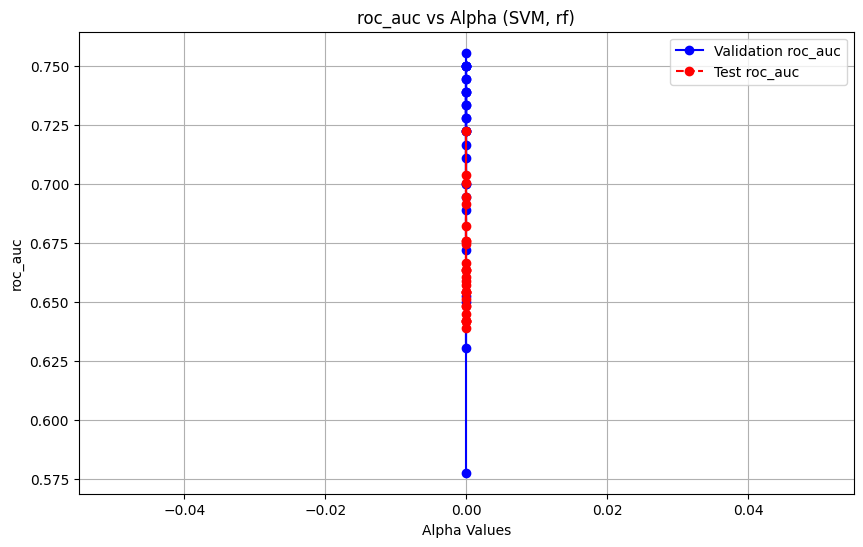

In [94]:
results_val_filtered = []
for res in results_val:
    if res['seed'] == 3:
        results_val_filtered.append(res)

METRICA = 'roc_auc'  # Define the metric you want to use

def plot_f1_vs_alpha(classifier, selector, metrica):
    """
    Plot F1 score vs alpha for both validation and test sets.
    """
    # Extract alpha and F1 score from validation results
    val_alpha_values = []
    val_f1_scores = []
    
    for result in results_val_filtered:
        if (result['classifier'] == classifier and
            result['selector'] == selector):
            if result['alpha'] is not None:
                val_alpha_values.append(result['alpha'])
                val_f1_scores.append(result[metrica])

    # Extract alpha and F1 score from test results
    test_alpha_values = []
    test_f1_scores = []
    
    for result in results_test:
        if (result['classifier'] == classifier and
            result['selector'] == selector):
            if result['alpha'] is not None:
                test_alpha_values.append(result['alpha'])
                test_f1_scores.append(result[metrica])

    # Plot the F1 score vs alpha for both validation and test
    plt.figure(figsize=(10, 6))
    
    plt.plot(val_alpha_values, val_f1_scores, label=f'Validation {metrica}', marker='o', linestyle='-', color='b')
    plt.plot(test_alpha_values, test_f1_scores, label=f'Test {metrica}', marker='o', linestyle='--', color='r')
    
    plt.title(f"{metrica} vs Alpha ({classifier}, {selector})")
    plt.xlabel('Alpha Values')
    plt.ylabel(f"{metrica}")
    plt.legend()
    
    plt.grid(True)
    plt.show()

# Example usage:
plot_f1_vs_alpha(
    classifier='MLP', 
    selector='logistic',
    metrica=METRICA
)


## plot per 2.5

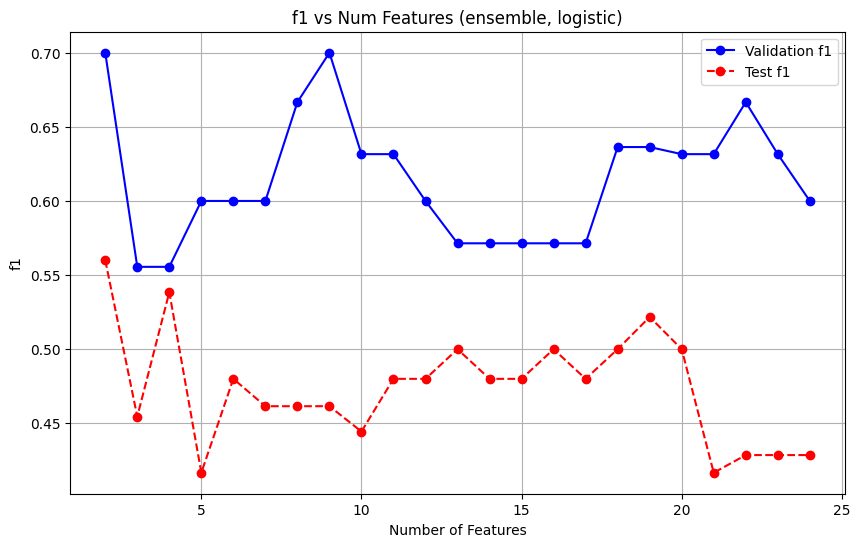

In [65]:

results_val_filtered=results_val

METRICA= 'f1' ## definisci la metrica che vuoi

def plot_f1_vs_num_features(classifier, selector, metrica, mode):
    """
    Plot F1 score vs num_features for both validation and test sets.
    """
    # Extract num_features and F1 score from validation results
    val_num_features = []
    val_f1_scores = []
    
    for result in results_val_filtered:
        if (result['classifier'] == classifier and
            result['selector'] == selector and 
            result['mode'] == mode) :
            if result['num_features'] is not None:
                val_num_features.append(result['num_features'])
                val_f1_scores.append(result[metrica])

    # Extract num_features and F1 score from test results
    test_num_features = []
    test_f1_scores = []
    
    for result in results_test:
        if (result['classifier'] == classifier and
            result['selector'] == selector and
            result['mode'] == mode) :
            if result['num_features'] is not None:
                test_num_features.append(result['num_features'])
                test_f1_scores.append(result[metrica])

    # Plot the F1 score vs num_features for both validation and test
    plt.figure(figsize=(10, 6))
    
    plt.plot(val_num_features, val_f1_scores, label=f'Validation {metrica}', marker='o', linestyle='-', color='b')
    plt.plot(test_num_features, test_f1_scores, label=f'Test {metrica}', marker='o', linestyle='--', color='r')
    
    plt.title(f"{metrica} vs Num Features ({classifier}, {selector})")
    plt.xlabel('Number of Features')
    plt.ylabel(f"{metrica}")
    plt.legend()
    
    plt.grid(True)
    plt.show()

# Example usage:
plot_f1_vs_num_features(
    classifier='ensemble', 
    selector='logistic',
    metrica= METRICA, 
    mode='Mean'
)


In [225]:


for j in range (0,1000):
    
    if (results_val[j]['mode']== 'Mean' and results_val[j]['selector']== 'mrmr' and results_val[j]['classifier']== 'XgBoost' and results_val[j]['num_features']== 24 ):
        print(results_val[j])
    else: 
        j=j+1


for j in range (0,1000):
    if (results_test[j]['mode']== 'Mean' and results_test[j]['selector']== 'mrmr' and results_test[j]['classifier']== 'XgBoost' and results_test[j]['num_features']== 24 ):
        print(results_test[j])
    else: 
        j=j+1

{'classifier': 'XgBoost', 'selector': 'mrmr', 'alpha': 0, 'num_features': 24, 'pr_auc': 0.6183452755821177, 'best_precision': 0.7777777777777778, 'best_recall': 0.5833333333333334, 'roc_auc': 0.6333333333333333, 'f1': 0.6666666666666666, 'accuracy': 0.7407407407407407, 'confusion_matrix': array([[13,  2],
       [ 5,  7]]), 'selected_features': [193, 14, 48, 1, 58, 79, 119, 65, 116, 244, 143, 231, 6, 3, 78, 19, 136, 221, 15, 51, 299, 85, 163, 108], 'mode': 'Mean'}
{'classifier': 'XgBoost', 'selector': 'mrmr', 'alpha': 0, 'num_features': 24, 'pr_auc': 0.5028391237108764, 'best_precision': 0.6363636363636364, 'best_recall': 0.5833333333333334, 'roc_auc': 0.7222222222222222, 'f1': 0.6086956521739131, 'accuracy': 0.7692307692307693, 'confusion_matrix': array([[23,  4],
       [ 5,  7]]), 'selected_features': [14, 48, 1, 79, 58, 119, 65, 116, 244, 143, 231, 6, 3, 78, 136, 19, 85, 221, 299, 51, 173, 108, 166, 109], 'mode': 'Mean'}


In [79]:
def find_best_num_features_and_print_metrics(results_val, results_test, metric='balanced accuracy', threshold=0.6):
    # Dictionary to store the best results per classifier, selector, and mode combination
    best_val_results = {}
    
    # Step 1: Find the best num_features for each combo (classifier, selector, mode) in the validation set
    for val_result in results_val:
        key = (val_result['classifier'], val_result['selector'], val_result['mode'])
        
        # Check if the combination is already present or if this result has a better metric value
        if key not in best_val_results or val_result[metric] > best_val_results[key][metric]:
            best_val_results[key] = val_result
    
    # Step 2: Print metrics for the best validation results and corresponding test results
    for key, best_val in best_val_results.items():
        classifier, selector, mode = key
        num_features = best_val['num_features']
        alpha = best_val['alpha'] if 'alpha' in best_val else None

        # Step 3: Find the corresponding test result for the same configuration
        corresponding_test = None
        for test_result in results_test:
            if test_result['classifier'] == classifier and \
               test_result['selector'] == selector and \
               test_result['mode'] == mode and \
               (test_result['num_features'] == num_features or (selector == 'lasso' and test_result['alpha'] == alpha)):
                corresponding_test = test_result
                break
        
        # Check if the test result meets the threshold for the chosen metric
        if corresponding_test and corresponding_test[metric] >= threshold:
            # Print Validation Set Metrics
            print(f"--- Best Validation Result for {classifier}, {selector}, Mode: {mode} ---")
            print(f"Num Features: {num_features}")
            if alpha:
                print(f"Alpha: {alpha}")
            print(f"Balanced Accuracy (Validation): {best_val['balanced accuracy']:.4f}")
            print(f"ROC AUC (Validation): {best_val['roc_auc']:.4f}")
            print(f"F1 Score (Validation): {best_val['f1']:.4f}")
            print(f"Accuracy (Validation): {best_val['accuracy']:.4f}")
            print(f"Confusion Matrix (Validation): \n{best_val['confusion_matrix']}")
            
            # Print Test Set Metrics
            print(f"\n--- Corresponding Test Result for {classifier}, {selector}, Mode: {mode} ---")
            print(f"Balanced Accuracy (Test): {corresponding_test['balanced accuracy']:.4f}")
            print(f"ROC AUC (Test): {corresponding_test['roc_auc']:.4f}")
            print(f"F1 Score (Test): {corresponding_test['f1']:.4f}")
            print(f"Accuracy (Test): {corresponding_test['accuracy']:.4f}")
            print(f"Confusion Matrix (Test): \n{corresponding_test['confusion_matrix']}")
            
            print("=" * 50 + "\n")
        #else:
            #print(f"No corresponding test result found with {metric} > {threshold} for {classifier}, {selector}, Mode: {mode}.\n")

# Example usage:
find_best_num_features_and_print_metrics(results_val, results_test, metric='balanced accuracy', threshold=0.6)


--- Best Validation Result for RandomForest, logistic, Mode: Mean ---
Num Features: 21
ROC AUC (Validation): 0.5389
F1 Score (Validation): 0.5926
Accuracy (Validation): 0.5926
Confusion Matrix (Validation): 
[[8 7]
 [4 8]]

--- Corresponding Test Result for RandomForest, logistic, Mode: Mean ---
ROC AUC (Test): 0.6512
F1 Score (Test): 0.4800
Accuracy (Test): 0.6667
Confusion Matrix (Test): 
[[20  7]
 [ 6  6]]

--- Best Validation Result for XgBoost, logistic, Mode: Mean ---
Num Features: 25
ROC AUC (Validation): 0.5889
F1 Score (Validation): 0.6154
Accuracy (Validation): 0.6296
Confusion Matrix (Validation): 
[[9 6]
 [4 8]]

--- Corresponding Test Result for XgBoost, logistic, Mode: Mean ---
ROC AUC (Test): 0.7006
F1 Score (Test): 0.5600
Accuracy (Test): 0.7179
Confusion Matrix (Test): 
[[21  6]
 [ 5  7]]

--- Best Validation Result for MLP, rf, Mode: Mean ---
Num Features: 11
ROC AUC (Validation): 0.4222
F1 Score (Validation): 0.2500
Accuracy (Validation): 0.5556
Confusion Matrix (Val

## GRAFICI VALUTAZIONE selector e classificatori globali

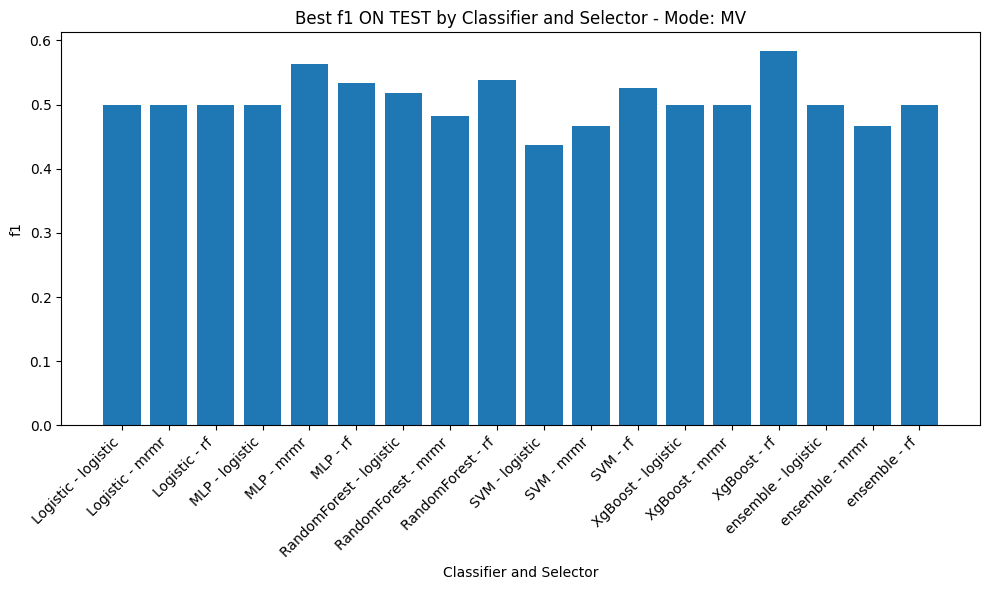

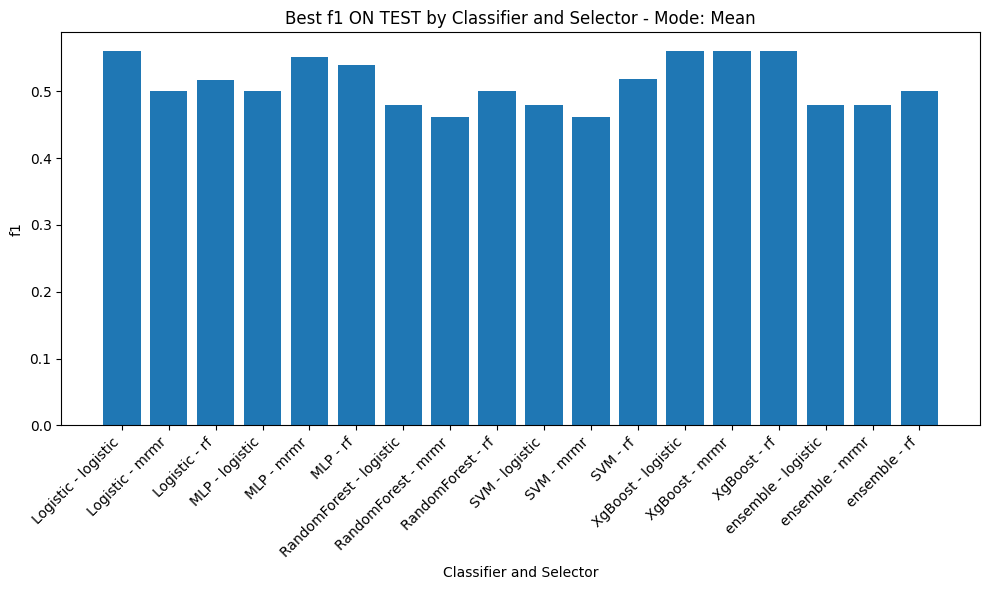

In [42]:

# Convert to DataFrame
df = pd.DataFrame(results_test)

# Assuming df is already loaded with your results
METRICA= 'f1'
# Filter by mode and selector 'mrmr', and select the best f1 for each classifier and selector
def get_best_results_by_mode(mode, df):
    # Filter by mode and selector = 'mrmr'
    #mode_df = df[(df['mode'] == mode) & (df['selector'].isin(['logistic']))]
    #mode_df = df[(df['mode'] == mode)]
    mode_df = df[(df['mode'] == mode) & (~df['selector'].isin(['lasso']))]
    best_results = mode_df.loc[mode_df.groupby(['classifier', 'selector'])[METRICA].idxmax()]
    return best_results

# Get the best results for both modes 'MV' and 'Mean', and only where selector='mrmr'
best_results_mv = get_best_results_by_mode('MV', df)
best_results_mean = get_best_results_by_mode('Mean', df)

# Create a plot for each mode
def plot_best_results(best_results, mode):
    fig, ax = plt.subplots(figsize=(10, 6))
    labels = []
    f1_values = []
    features_or_alpha_values = []
    
    for index, row in best_results.iterrows():
        label = f"{row['classifier']} - {row['selector']}"
        features_or_alpha = row['alpha'] if row['selector'] == 'lasso' else row['num_features']
        labels.append(label)
        f1_values.append(row['f1'])
        features_or_alpha_values.append(features_or_alpha)
    
    ax.bar(labels, f1_values)
    ax.set_title(f"Best {METRICA} ON TEST by Classifier and Selector - Mode: {mode}")
    ax.set_xlabel("Classifier and Selector")
    ax.set_ylabel(f"{METRICA}")
    
    # Annotate the bars with the number of features/alpha
    #for i, val in enumerate(f1_values):
        #ax.text(i, val + 0.01, f"features/alpha: {features_or_alpha_values[i]}", ha='center', va='bottom')

    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Plot for MV mode with selector 'mrmr'
plot_best_results(best_results_mv, 'MV')

# Plot for Mean mode with selector 'mrmr'
plot_best_results(best_results_mean, 'Mean')



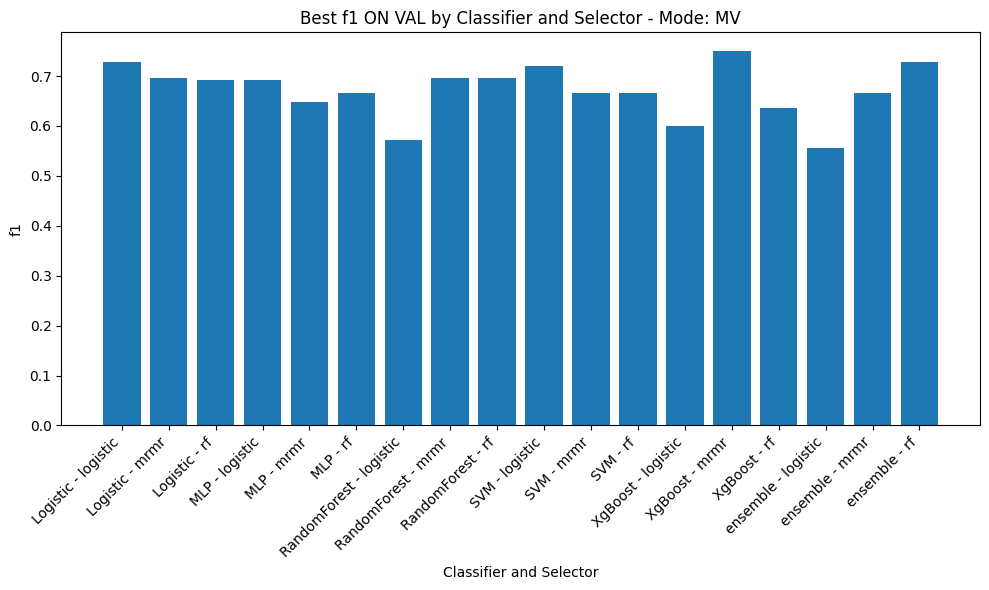

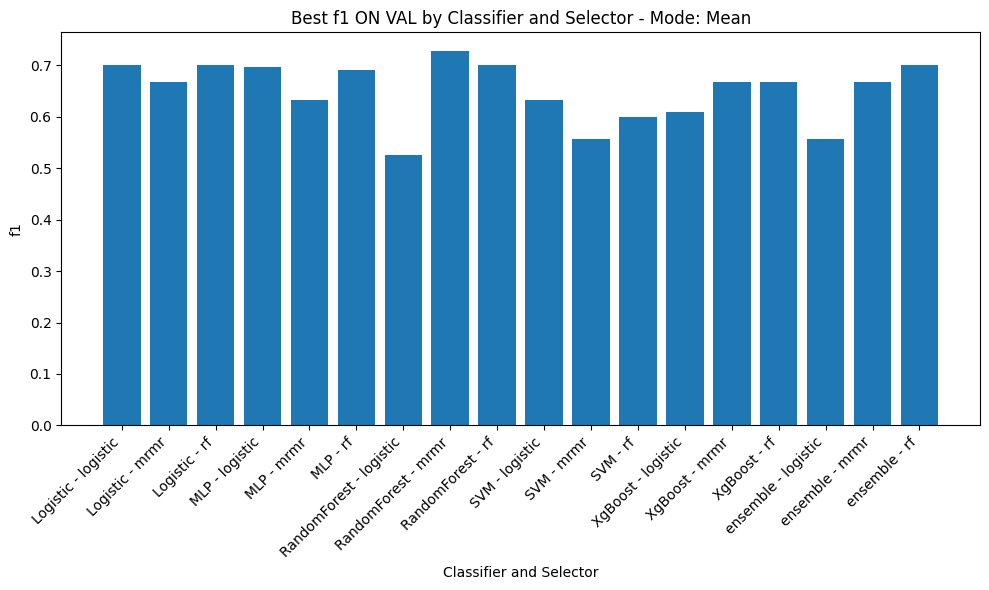

In [44]:

# Convert to DataFrame
df = pd.DataFrame(results_val)

# Assuming df is already loaded with your results
METRICA='f1'
# Filter by mode and selector 'mrmr', and select the best f1 for each classifier and selector
def get_best_results_by_mode(mode, df):
    # Filter by mode and selector = 'mrmr'
    #mode_df = df[(df['mode'] == mode) & (df['selector'] == 'logistic')]
    mode_df = df[(df['mode'] == mode) & (~df['selector'].isin(['lasso']))]
    #mode_df = df[(df['mode'] == mode)]
    #mode_df = df[(df['mode'] == mode) & (~df['classifier'].isin(['SVM', 'XgBoost']))]

    best_results = mode_df.loc[mode_df.groupby(['classifier', 'selector'])[METRICA].idxmax()]
    return best_results

# Get the best results for both modes 'MV' and 'Mean', and only where selector='mrmr'
best_results_mv = get_best_results_by_mode('MV', df)
best_results_mean = get_best_results_by_mode('Mean', df)

# Create a plot for each mode
def plot_best_results(best_results, mode):
    fig, ax = plt.subplots(figsize=(10, 6))
    labels = []
    f1_values = []
    features_or_alpha_values = []
    
    for index, row in best_results.iterrows():
        label = f"{row['classifier']} - {row['selector']}"
        features_or_alpha = row['alpha'] if row['selector'] == 'lasso' else row['num_features']
        labels.append(label)
        f1_values.append(row[METRICA])
        features_or_alpha_values.append(features_or_alpha)
    
    ax.bar(labels, f1_values)
    ax.set_title(f"Best {METRICA} ON VAL by Classifier and Selector - Mode: {mode}")
    ax.set_xlabel("Classifier and Selector")
    ax.set_ylabel(f"{METRICA}")
    
    # Annotate the bars with the number of features/alpha
    #for i, val in enumerate(f1_values):
        #ax.text(i, val + 0.01, f"features/alpha: {features_or_alpha_values[i]}", ha='center', va='bottom')

    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Plot for MV mode with selector 'mrmr'
plot_best_results(best_results_mv, 'MV')

# Plot for Mean mode with selector 'mrmr'
plot_best_results(best_results_mean, 'Mean')

